# Homework 1 Solutions:

# Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

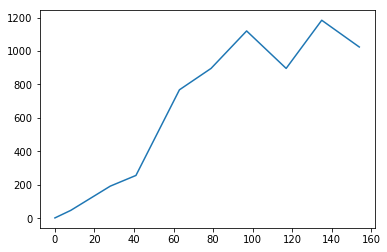

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using the Newton–Raphson approach to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

### Solution to part 1

Here's an arbitrary (non-optimal) solution, which we can use as a starting point to improve:

In [50]:
K0, r0 = 1000, 0.1

logistic = lambda t, K, r, N0=1.: K*N0 / (N0 + (K-N0) * np.exp(-r*t))

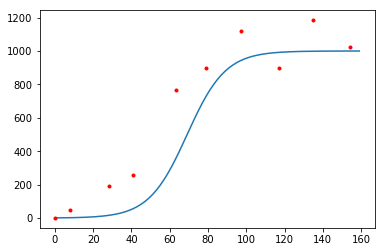

In [51]:
times = np.arange(160)
plt.plot(times, logistic(times, K0, r0))
plt.plot(days, beetles, 'r.')

In [52]:
def mse(params):
    K, r = params
    return np.mean([(logistic(t, K, r) - y)**2 for t,y in zip(days, beetles)])

In [53]:
mse([1000, 0.1])

34826.299294607059

In [54]:
from scipy.optimize import fmin_l_bfgs_b

opt = fmin_l_bfgs_b(mse, (1000, 0.1), approx_grad=True)
opt

(array([  1.02870123e+03,   1.30426986e-01]),
 9427.6719304894905,
 {'funcalls': 90,
  'grad': array([ -3.63797881e-04,   7.49605533e-01]),
  'nit': 23,
  'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

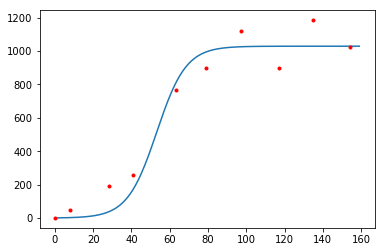

In [55]:
K_opt, r_opt = opt[0]

plt.plot(times, logistic(times, K_opt, r_opt))
plt.plot(days, beetles, 'r.')

### Solution To part 2  

In [59]:
# Log-likelihood for distribution of log(Nt)
def logistic_growth(r, K, N0 = 2):
    # Calculate the predicted population (Nt) at each time t in days
    pred_popn = [(K * N0)/(N0 + (K - N0)*np.exp(-r * t)) for t in days]
    return(pred_popn)
def normal_loglike(par, x = np.log(beetles)):
    # Parameters for which we seek maximum likelihood estimates
    r = par[0]
    K = par[1]
    s2 = par[2]
    
    # Compute the mean
    # Note that from the way my logistic_growth function was written above, 
    #  `mu` is a vector with a different mean associated for each value of `days`
    mu = np.log(logistic_growth(r, K))
    
    # Without this next line, the algorithm occasionally tries to use a non-positive
    #  variance when exploring the parameter space which causes issues during optimization
    # To solve, we keep variance > 0 by saying if var <= 0 force log-likelihood value 
    #  to be really large so it won't get selected as the best estimate
    if s2 <= 0: return 1e10
    
    # Compute the log-likelihood
    log_like = (-1/2) * np.sum(np.log(2 * np.pi) + np.log(s2) + (1/s2)*(x - mu)**2)
    # Negate because we want to maximize and we will be using optimize.minimize
    return -log_like

Now we use `optimize.minimize` to obtain the maximum likelihood estimates. The output of `optimize.minimize` provides the inverse Hessian (matrix of second derivatives). When the function of interest is the (log-)likelihood, the inverse of the negative Hessian is the covariance matrix. Since our function of interest is the *negative* (log-)likelihood, the inverse Hessian provided by the code output is the covariance matrix of our maximum likelihood estimates. The standard errors are simply the square root of the diagonal elements, and we use these and the the covariances to compute correlations:  

$$Corr(X, Y) = \cfrac{Cov(X, Y)}{\sigma_X \sigma_Y})$$  

As shown from the output below, the desired estimates are:  

$$\begin{aligned}
\text{Maximum Likelihood Estimates } (\hat{r}, \hat{K}, \hat{\sigma^2}) = (0.4,\ 672,\ 0.343) \\
\text{Standard Errors of } (\hat{r}, \hat{K}, \hat{\sigma^2}) = (0.082,\ 139.4,\ 0.153) \\
\text{Correlations between } \bigg( (\hat{r}, \hat{K}) , (\hat{r}, \hat{\sigma^2}), (\hat{K}, \hat{\sigma^2}) \bigg) = (-0.037,\ 0.015,\ -0.004) \\
\end{aligned}$$

In [60]:
import scipy as sp
mle_res = sp.optimize.minimize(normal_loglike, [.01, 1500, 1], 
                            options={'disp': True})
mle_res

         Current function value: 8.842811
         Iterations: 42
         Function evaluations: 396
         Gradient evaluations: 79


      fun: 8.842810568282331
 hess_inv: array([[  6.99380902e-03,   2.30763439e-03,   7.28728120e-05],
       [  2.30763439e-03,   2.97099642e-02,  -7.80652632e-03],
       [  7.28728120e-05,  -7.80652632e-03,   2.34855339e-02]])
      jac: array([  1.94311142e-05,  -1.19209290e-07,  -1.39474869e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 396
      nit: 42
     njev: 79
   status: 2
  success: False
        x: array([  4.00461073e-01,   6.72088483e+02,   3.43243239e-01])

In [61]:
# Best values of r, K, sigma^2
mle_est = mle_res['x']
mle_est

array([  4.00461073e-01,   6.72088483e+02,   3.43243239e-01])

In [62]:
#### Estimates of standard error
cov_mat = mle_res['hess_inv']
se_est = np.sqrt(np.diagonal(cov_mat))
se_est

array([ 0.083629  ,  0.17236579,  0.15324991])

In [63]:
# Estimates of correlation between the parameters
# corr(x,y) = cov(x,y)/(sd_x * sd_y)

corr = [cov_mat[0][1]/(se_est[0] * se_est[1]), # between r and K
        cov_mat[0][2]/(se_est[0] * se_est[2]), # between r and sigma^2
        cov_mat[1][2]/(se_est[1] * se_est[2])] # between K and sigma^2
corr

[0.16008810122493922, 0.0056860205481549797, -0.29553338319942896]

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.




In [24]:
import pandas as pd

baseball = pd.read_table('/Users/schluetd/Bios8366-1/data/baseball.dat', sep='\s+')

logsalary = baseball.salary.apply(np.log)
predictors = baseball.ix[:, 'average':]
nrows, ncols = predictors.shape

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [32]:
# n * ln(SSE/n) - k * ln(n)
aic = lambda g: g.nobs * np.log((g.resid**2).sum()/g.nobs) + 2*len(g.beta)

Best AIC: -416.2164301596406
Best solution: (array([ 2,  7,  9, 12, 13, 14, 17, 19, 20, 21, 24, 25]),)
Discovered at iteration 367


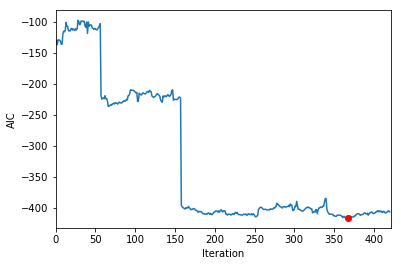

In [41]:
from sklearn.linear_model import LinearRegression
#Make a copy. Define some parameters and functions
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

#aic function
aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

#First set of temperature
tau_start = 100
cooling_schedule = [tau_start]*60 + [tau_start/10]*120 + [tau_start/20]*240 

def anneal(periods, period_lengths, cooling_schedule, nbrhd=1):
    
    aic_values = []
    #Initialize the annealing run and temperature schedule
    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    g = LinearRegression().fit(X=solution_vars, y=logsalary)
    aic_best = aic(g, solution_vars, logsalary)
    aic_values.append(aic_best)
    for tau in cooling_schedule:

        # Random change 1-neighborhood
        flip = np.random.randint(0, ncols)
        #if the value is not included, not just let it include
        solution_current[flip] = not solution_current[flip]
        solution_vars = predictors[predictors.columns[solution_current]]
        g = LinearRegression().fit(X=solution_vars, y=logsalary)
        aic_step = aic(g, solution_vars, logsalary)
        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))

        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            aic_values.append(aic_step)
            if aic_step < aic_best:
                # Replace previous best with this one
                aic_best = aic_step
                solution_best = solution_current.copy()
        else:
            # Revert solution
            solution_current[flip] = not solution_current[flip]
            aic_values.append(aic_values[-1])
        return solution_best, aic_values
#Draw the plots   

solution_best, aic_values = anneal()
plt.plot(aic_values)
plt.xlim(0, len(aic_values))
plt.xlabel('Iteration')
plt.ylabel('AIC')
print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
            np.where(solution_best==True),
            np.where(aic_values==aic_best)[0][0]))
plt.plot(np.where(aic_values==aic_best)[0][0], aic_best, 'ro')

In [1]:
periods = 15
period_lengths = [60]*(periods/3) + [120]*(periods/3) + [220]*(periods/3)
tau_start = 10
cooling_schedule = [tau_start * 0.9**i for i in range(periods)]

def anneal(periods, period_lengths, cooling_schedule, nbrhd=1):
    
    aic_values = []
    tau = cooling_schedule
    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    g = pd.ols(y=logsalary, x=solution_vars)
    aic_best = aic(g)
    aic_values.append(aic_best)
    
    for j in range(periods):
    
        for i in range(period_lengths[j]):
            
            solution_step = solution_current.copy()
            
            flip = np.random.randint(0, ncols, nbrhd)
            solution_step[flip] = solution_current[flip] - True
            solution_vars = predictors[predictors.columns[solution_step]]
            g = pd.ols(y=logsalary, x=solution_vars)
            aic_step = aic(g)
            alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau[j]))
            
            if ((aic_step < aic_values[-1]) or (random.uniform() < alpha)):
                # Accept proposed solution
                solution_current = solution_step.copy()
                aic_values.append(aic_step)
                if aic_step < aic_best:
                    # Replace previous best with this one
                    aic_best = aic_step
                    solution_best = solution_step.copy()
            else:
                # Retain current solution
                aic_values.append(aic_values[-1])
                
    return solution_best, aic_values

TypeError: can't multiply sequence by non-int of type 'float'

### NEw solution 


### Solution (1)  
*1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class.*  

After reading in the baseball data, we define the function `aic` to compute AIC from a regression model and `sim_anneal` to perform the simulated annealing algorithm. Most of the code for these functions is obtained from the class notebook for Section 1_2: Combinatorial Optimization. I have added comments and made edits necessary to answer the problems at hand.



In [22]:
from sklearn.linear_model import LinearRegression
import matplotlib.lines as mlines
import pandas as pd



In [23]:
baseball = pd.read_table('/Users/schluetd/Bios8366-1/data/baseball.dat', sep='\s+')

In [26]:
# Initialize variables we will need
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

In [27]:
# Define an AIC function and compute the model AIC
aic = lambda f, X, y: len(y) * np.log(sum((f.predict(X) - y)**2)/len(y)) + 2*f.rank_

In [28]:
# T/F vector indicating whether or not each column is included in the model
# This is defined outside the loop so that all four cooling schedules will start at the same place,
#  making for a more fair comparison
solution_initial = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)

In [29]:
# Define simulated annealing function
def sim_anneal(cooling_schedule, nbhd = 1, data = baseball, start = solution_initial):
    
    # Design matrix associated with what variables are currently included
    solution_current = solution_best = start
    solution_vars = predictors[predictors.columns[solution_current]]

    # Fit the linear regression model based on the current design matrix
    fit = LinearRegression().fit(X=solution_vars, y=logsalary)
    
    # Keep the AIC for this model
    aic_values = []
    aic_best = aic(fit, solution_vars, logsalary)
    aic_values.append(aic_best)

    # Apply cooling schedule
    for tau in cooling_schedule:

        # Column(s) index(es) to flip (number of cols determined by neighborhood size)
        flip = np.random.randint(0, ncols, size=nbhd)
        # Flip the value (included/excluded) of the column
        # Vectorized for the case where nbhd > 1
        solution_current[flip] = [not solution_current[i] for i in flip]
        
        # Get associated design matrix and fit a new linear regression, keeping the AIC
        solution_vars = predictors[predictors.columns[solution_current]]
        fit = LinearRegression().fit(X=solution_vars, y=logsalary)
        
        # AIC of proposed solution
        aic_step = aic(fit, solution_vars, logsalary)
        
        # Probability with which we will accept the proposed solution 
        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))
        
        # Accept if the solution is better than the last solution
        #  or with probability alpha if it is worse than the last solution
        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            aic_values.append(aic_step)
            if aic_step < aic_best:
                # Replace previous best with this one
                aic_best = aic_step
                solution_best = solution_current.copy()
        else:
            # Revert to previous iteration (reject proposed solution)
            solution_current[flip] = [not solution_current[i] for i in flip]
            aic_values.append(aic_values[-1])
    
    return aic_values, aic_best, solution_best

### (1A)

*A. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).*  

Four different cooling schedules will be considered, classified as either *slow* or *rapid* and as either *discrete* or *smooth*. Below we graphically display what the four cooling cycles look like.

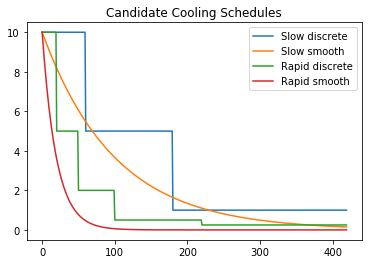

In [30]:
# Demonstrate what the cooling cycles look like
tau_start = 10
cs1 = [tau_start]*60 + [tau_start/2]*120 + [tau_start/10]*240
cs2 = [tau_start*0.99**i for i in range(420)]
cs3 = [tau_start]*20 + [tau_start*.5]*30 + [tau_start*.20]*50 + [tau_start*.05]*120 + [tau_start * .025]*200
cs4 = [tau_start*0.95**i for i in range(420)]

plt.plot(cs1)
plt.plot(cs2)
plt.plot(cs3)
plt.plot(cs4)
plt.legend(["Slow discrete", "Slow smooth",
           "Rapid discrete", "Rapid smooth"])
plt.title("Candidate Cooling Schedules")

In [31]:
# Function to plot the AIC results of the simulated annealing algorithm
def plot_sim_anneal(cooling_schedule, cs_name, color, nbhd = 1):
    model = sim_anneal(cooling_schedule, nbhd)
    all_aics = model[0]
    best_aic = model[1]
    best_soln = model[2]

    plt.plot(all_aics, c = color)
    plt.xlim(0, len(all_aics))
    plt.xlabel('Iteration')
    plt.ylabel('AIC')
    print('Cooling Schedule: {0}\nBest AIC: {1}\nBest solution: {2}\nDiscovered at iteration {3}\n'.format(
                cs_name,
                best_aic, 
                baseball.columns[np.where(best_soln==True)],
                np.where(all_aics==best_aic)[0][0]))   
    plt.plot(np.where(all_aics==best_aic)[0][0], best_aic, 'o', c = color)

The simulated annealing algorithm is performed for each cooling schedule below. For these results, the neighborhood was fixed to be 1. The text output provided before the plot indicates the best achieved AIC, the best solution (i.e. the columns included in the best model), and the iteration at which the best was achieved.

Cooling Schedule: Slow discrete
Best AIC: -418.1503563585163
Best solution: Index(['obp', 'homeruns', 'walks', 'sbs', 'errors', 'freeagent', 'arbitration',
       'runsperso', 'walksperso', 'runspererror', 'soserrors', 'sbsruns'],
      dtype='object')
Discovered at iteration 340

Cooling Schedule: Slow smooth
Best AIC: -420.9420793003548
Best solution: Index(['salary', 'obp', 'doubles', 'homeruns', 'walks', 'errors', 'freeagent',
       'arbitration', 'runsperso', 'hrspererror', 'soserrors', 'sbsobp'],
      dtype='object')
Discovered at iteration 401

Cooling Schedule: Rapid discrete
Best AIC: -420.9420793003548
Best solution: Index(['salary', 'obp', 'doubles', 'homeruns', 'walks', 'errors', 'freeagent',
       'arbitration', 'runsperso', 'hrspererror', 'soserrors', 'sbsobp'],
      dtype='object')
Discovered at iteration 0

Cooling Schedule: Rapid smooth
Best AIC: -420.9420793003548
Best solution: Index(['salary', 'obp', 'homeruns', 'walks', 'errors', 'freeagent',
       'arbitratio

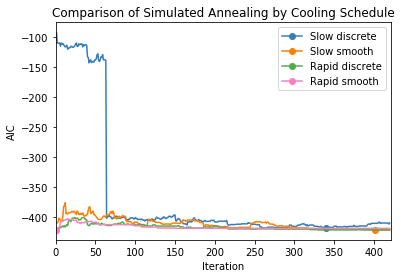

In [32]:
# First cooling schedule:
plot_sim_anneal(cs1, cs_name = "Slow discrete", color = '#377eb8')
plot_sim_anneal(cs2, cs_name = "Slow smooth", color = '#ff7f00')
plot_sim_anneal(cs3, cs_name = "Rapid discrete", color = '#4daf4a')
plot_sim_anneal(cs4, cs_name = "Rapid smooth", color = '#f781bf')


line1 = mlines.Line2D([], [], color='#377eb8', marker='o',label='Slow discrete')
line2 = mlines.Line2D([], [], color='#ff7f00', marker='o', label='Slow smooth')
line3 = mlines.Line2D([], [], color='#4daf4a', marker='o',label='Rapid discrete')
line4 = mlines.Line2D([], [], color='#f781bf', marker='o', label='Rapid smooth')
plt.legend(handles=[line1, line2, line3, line4], loc="upper right")
plt.title("Comparison of Simulated Annealing by Cooling Schedule")

The rapid smooth cooling schedule was the quickest to find its best soltution and stabilized much earlier, while still doing some minor exploration. The rapid discrete also remained closer to optimal AIC values, though the slow discrete found its best AIC some iterations earlier. The slow methods, both smooth and discrete, explored the model space much more, as evidenced by their more variable trend lines. The slow cooling schedules took the longest to stabilize. Generally, it appears that the rapid methods move toward optimal solutions, though they explore the model space much less.  

We can also see that while there is a good bit of overlap, the solutions between the four cooling schedules are not identical. That is, different variables were included in the model. This illustrates a known issue with variable selection methods in that they can be quite volatile and difficult to consistently reproduce.

### (1B)  

*B. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.*  

For this problem, we will compare the 2- vs 3-neighborhood scenarios for two different cooling schedules from part (A): the slow smooth (`cs2`) and rapid discrete (`cs3`). The neighborhood size determines how many columns are having their inclusion/exclusion status changed on a given iteration. With a larger neighborhood, we are changing the model more drastically each iteration so we will be exploring the model space more.

Cooling Schedule: k=2
Best AIC: -420.0922138685676
Best solution: Index(['salary', 'obp', 'doubles', 'homeruns', 'walks', 'errors', 'freeagent',
       'arbitration', 'runsperso', 'hitsperso', 'hrspererror', 'soserrors',
       'sbsobp'],
      dtype='object')
Discovered at iteration 399

Cooling Schedule: k=3
Best AIC: -420.45106190483517
Best solution: Index(['salary', 'obp', 'homeruns', 'walks', 'errors', 'freeagent',
       'arbitration', 'runsperso', 'hrspererror', 'soserrors', 'sbsobp'],
      dtype='object')
Discovered at iteration 408



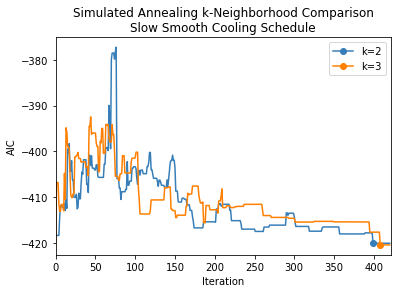

In [33]:
# Slow smooth
plot_sim_anneal(cs2, nbhd = 2, cs_name = "k=2", color = '#377eb8')
plot_sim_anneal(cs2, nbhd = 3, cs_name = "k=3", color = '#ff7f00')

line1 = mlines.Line2D([], [], color='#377eb8', marker='o',label='k=2')
line2 = mlines.Line2D([], [], color='#ff7f00', marker='o', label='k=3')
plt.legend(handles=[line1, line2], loc="upper right")
plt.title("Simulated Annealing k-Neighborhood Comparison\nSlow Smooth Cooling Schedule")

For the slow smooth cooling schedule, we observe that in the case where the proposal distribution is discrete uniform across three neighborhoods, the annealing algorithm takes longer to achieve it's best AIC. It appears as though both neighborhood options explore the model space a good amount (the curves are highly variable). The AIC selected by the model where k=2 found a slightly more optimal model with lower AIC.

Cooling Schedule: k=2
Best AIC: -420.9472114371548
Best solution: Index(['average', 'obp', 'doubles', 'homeruns', 'walks', 'errors', 'freeagent',
       'arbitration', 'runsperso', 'hrspererror', 'soserrors', 'sbsobp'],
      dtype='object')
Discovered at iteration 300

Cooling Schedule: k=3
Best AIC: -420.9472114371548
Best solution: Index(['average', 'obp', 'doubles', 'homeruns', 'walks', 'sos', 'errors',
       'freeagent', 'arbitration', 'runsperso', 'hrspererror', 'soserrors',
       'sbsobp'],
      dtype='object')
Discovered at iteration 0



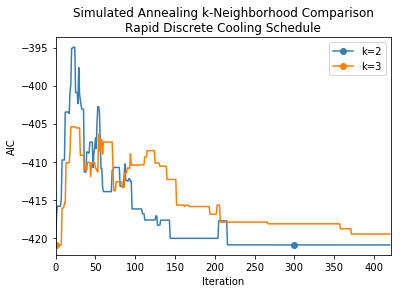

In [34]:
# Rapid discrete
plot_sim_anneal(cs3, nbhd = 2, cs_name = "k=2", color = '#377eb8')
plot_sim_anneal(cs3, nbhd = 3, cs_name = "k=3", color = '#ff7f00')

line1 = mlines.Line2D([], [], color='#377eb8', marker='o',label='k=2')
line2 = mlines.Line2D([], [], color='#ff7f00', marker='o', label='k=3')
plt.legend(handles=[line1, line2], loc="upper right")
plt.title("Simulated Annealing k-Neighborhood Comparison\nRapid Discrete Cooling Schedule")

The lines are smoother in this plot since we are using a more rapid cooling schedule. In this case, the scenario with k=3 achieves its best AIC sooner, but then explores the model space more and is unable to achieve as good an AIC again. It may have just gotten lucky with its start model and explored too much and arrived in an alternative local minimum. The scenario with k=2 tended to get to a more optimal solution more quickly. The differences would likely be more prominent if we were to increase the discrepancy in k values.

### Solution (2)

*2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5.*  

Using the same `aic` function defined in part (1), we write a function `gen_alg` to implement the genetic algorithm. Most of the code for these functions is obtained from the class notebook for Section 1_2: Combinatorial Optimization. I have added comments and made edits necessary to answer the problems at hand.  

Modeling this solution off of Example 3.5 in the notes, by default the first parent ("moms" will be chosen according to fitness for parts A and B. In part C, we consider when both parents ("moms" and "dads") are chosen according to fitness. Fitness is defined using the rank of the AIC values.

In [35]:
# Read data and initialize variables we will need
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

In [36]:
# Weight by AIC rank - when choosing parents based on fitness
def calculate_fitness(aic_val):
    P = len(aic_val)
    aic_rank = (-aic_val).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

In [37]:
# Function for performing genetic algorithm
def gen_alg(pop_size, mutation_rate, initial_gen, iterations = 200, data = baseball, bothfit = False):
    
    # Initialize storage lists
    aic_best = []
    best_solution = []
    aic_history = []
    
    current_gen = initial_gen
    
    for i in range(iterations):
        
        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        if bothfit == True:
            # Choose second parents according to fitness
            dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        else:
            # Choose second parents randomly - done uniformly by default when p not specified
            dads = np.random.choice(range(pop_size), size=int(pop_size/2))
        # The above choices for p modifies rate of exploration vs convergence

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate -  is there a mutation now?
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2] 

        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
        
    return aic_history, aic_best, solution_best 

### (2A)   
 
*A. Compare the effects of using different mutation rates.*  

First, we investigate the role of the mutation rate in finding a solution through the genetic algorithm. To ensure that comparisons will be fair, the different mutation rates under consideration will all start from the same population. For this investigation we will use a population size of 20. After creating our initial population, we write a function that will plot the AIC results for fitting a linear regression of the baseball data throughout the genetic algorithm. We consider mutation rates of varying size: .001, .01, .02, .05, .1.

In [38]:
# Fixed population size of 20 to compare mutation rates
# All start with same population
ps = 20
start = np.random.binomial(1, 0.5, ps*ncols).reshape((ps, ncols))

In [39]:
# Function to plot the AIC results of the genetic algorithm
def plot_gen_alg(pop_size, mutation_rate, init_gen, color, iterations = 200, fit = "First", bothfit = False):
    # Fit the genetic algorithm model and save output
    model = gen_alg(pop_size = pop_size, mutation_rate = mutation_rate, 
                    iterations = iterations, initial_gen = init_gen, bothfit = bothfit)
    all_aics = model[0]
    best_aic = model[1]
    best_soln = model[2]
    
    # Plot the tracking of best AIC over iterations
    plt.plot(best_aic, c = color)
    plt.xlim(0, len(best_aic))
    plt.xlabel('Iteration')
    plt.ylabel('AIC')

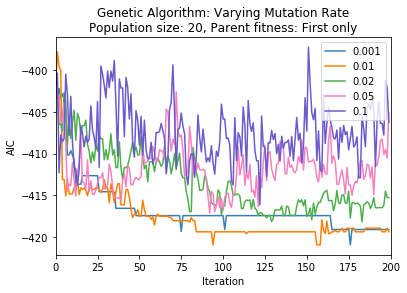

In [40]:
# Specify mutation rates and corresponding plotting colors
mut_rates = [.001,.01,.02,.05,.1]
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#6a5acd"]

# Implement the genetic algorithm for each mutation rate and plot the results
[plot_gen_alg(pop_size = 20, mutation_rate = mr, init_gen = start, color = col) for 
 (mr, col) in zip(mut_rates, colors)]
plt.title('Genetic Algorithm: Varying Mutation Rate\nPopulation size: {0}, Parent fitness: {1}'.format(
                "20", "First only"))
plt.legend(mut_rates, loc="upper right")

We see that as the mutation rate increases, the lines become much more erratic because the population has a higher chance of experiencing random mutation. It is more difficult in this case to stay close to an optimal solution with a higher mutation rate. For the very low mutation rates (.001 and .01), we see that the AIC trend quickly heads toward a more optimal solution and remains there once achieved.

### (2B)   
 
*B. Compare the effects of using different generation sizes.*  

(When I say population sizes through this problem, I mean generation sizes.) For this next part, we will fix the mutation rate at .02 and consider varying population sizes: 10, 20, 50, 100, 200.

In [ ]:
# Specify population sizes and corresponding plotting colors
p_sizes = [10, 20, 50, 100, 200]
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#6a5acd"]

# Create starting population for each population size
pop_start = [np.random.binomial(1, 0.5, p*ncols).reshape((p, ncols)) for p in p_sizes]

# Implement the genetic algorithm for each population size and plot the results
[plot_gen_alg(pop_size = ps, mutation_rate = .02, init_gen = p_start, color = col) for 
 (ps, p_start, col) in zip(p_sizes, pop_start, colors)]

plt.ylim(-425,-390)
plt.title('Genetic Algorithm: Varying Population size\nMutation rate: {0}, Parent fitness: {1}'.format(
                ".02", "First only"))
plt.legend(p_sizes)

As generation size increases, the algorithm becomes more stable and is better able to find an optimal solution. There are more candidate members used in "breeding," making it easier to obtain an better combinations for creating offspring. The scenarios run with smaller generation size are never able to achieve the level of success of the larger generations.

### (2C)   
 
*C. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.*  

For this comparison, we will implement the genetic algorithm comparing the case when the first parent is chosen by fitness and the second is random with the case where both parents are selected by fitness. Since it is a single comparison, we'll compare the two scenarios under a few different population sizes and mutation rates.

In [ ]:
# Specify mutation rates and population sizes
pop_prod = list(it.product([.001, .01], [20, 100]))

# The pop_start values are the initial populations from part B associated with population
#  sizes of 20 and 100, respectively
popn_start = [pop_start[1], pop_start[3], pop_start[1], pop_start[3]]

# Only first parent fit
[plot_gen_alg(pop_size = pop[1], mutation_rate = pop[0], init_gen = p_start, color = "#377eb8", 
              bothfit = False) for (pop, p_start) in zip(pop_prod, popn_start)]

# Both fit
[plot_gen_alg(pop_size = pop[1], mutation_rate = pop[0], init_gen = p_start, color = "#ff7f00", 
              bothfit = True) for (pop, p_start) in zip(pop_prod, popn_start)]

plt.title('Genetic Algorithm: Varying Parent Fitness')
one = mlines.Line2D([], [], color='#377eb8', marker='',label='One fit, one random')
two = mlines.Line2D([], [], color='#ff7f00', marker='', label='Both fit')
plt.legend(handles=[one, two], loc="upper right")

From the above we see that when choosing parents based on both being fit, the algorithm seems to converge more quickly and more consistently. In the case where one parent is chosen randomly, there is much more exploration of the model space. Occasionally, the one fit/one random case is able to achieve an AIC as low as the both fit cases. However, it often takes many more iterations to achieve this.

# Question 3:

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there). 

Here is one solution using a Genetic algorithm. 

In [ ]:
from functools import lru_cache

def makeRoute(numCities = 26):
    """
    Takes a given number of cities and makes a random route 
    between them starting and ending at the first city
    """
    innerRoute = np.random.permutation(np.arange(1, numCities))
    return np.concatenate(([0], innerRoute, [0]))

def npIndex(arr, el): 
    "Small helper to get the first location in numpy array of a given element"
    np.where(arr == el)[0][0]

def breedRoutes(routeOne, routeTwo, mutationRate = 0.01):
    """
    Takes a two routes represented as a numpy vector [0, 4, 6, ..., 0]
    and breeds them together to create a new route. 
    All points where the routes differ are swaped with 50% chance to the 
    offspring. 
    In addition to swapping of position a binomial random draw is made to 
    decide how many random mutation are incurred in the route according to the
    mutation rate. 
    """
    swapProb = 0.5
    newRoute = routeOne.copy()
    swaps = [[one, two] for (one, two) in zip(routeOne, routeTwo) if one != two]

    for swap in swaps:
        if np.random.binomial(1, swapProb) == 1:
            firstInd  = npIndex(newRoute,swap[0])
            secondInd = npIndex(newRoute,swap[1])
            newRoute[firstInd], newRoute[secondInd] = newRoute[secondInd], newRoute[firstInd]
    
    # see how many random mutations we get. 
    numRandMutation = np.random.binomial(n = len(routeOne) - 2, p = mutationRate)
    for i in range(numRandMutation):
        firstInd  = np.random.randint(low = 1, high = len(routeOne) - 2)
        secondInd = np.random.randint(low = 1, high = len(routeOne) - 2)
        newRoute[firstInd], newRoute[secondInd] = newRoute[secondInd], newRoute[firstInd]
    return newRoute


# @lru_cache(maxsize=None)
def distanceApart(city1, city2):
    """
    Calculate distance between two given cities using the Haversine distance.
    This assumes that the world is perfectly sphearicle which is obviously false
    But given the relatively small geographical range of our cities is an
    acceptable simplification.
    """
    c1Lat, c1Lon = cities.iloc[city1]
    c2Lat, c2Lon = cities.iloc[city2]
    dist = gpxpy.geo.haversine_distance(c1Lat, c1Lon, c2Lat, c2Lon)
    return dist

def citiesToString(city1, city2):
    return "%i_%i" % (city1, city2)

def citiesFromString(cityPath):
    cities = cityPath.split("_")
    city1 = int(float(cities[0]))
    city2 = int(float(cities[1]))
    return city1, city2

@lru_cache(maxsize=None)
def distanceApartMemo(cityPath):
    city1, city2 = citiesFromString(cityPath)
    return distanceApart(city1, city2)

# @lru_cache(maxsize=None)
def routeLength(route):
    """
    Takes a route in the numpy array form and returns the total distance traveled
    Units are kilometers, uses the distanceApart function above and thus the 
    Haversine distance as well.
    """
    # Make an offset array to create paths with
    toArray = np.concatenate(([0], route))
    # Memoized version
    routeSteps = [distanceApartMemo(citiesToString(city1, city2)) for (city1, city2) in zip(toArray, route)][1:]
    # return the summed distances
    return sum(routeSteps)

def calcFitness(routeLengths):
    P = len(routeLengths)
    lengthRank = (-np.array(routeLengths)).argsort().argsort()+1.
    return 2.*lengthRank/(P*(P+1.))

def mutatingSalesman(generationSize, numberGenerations, mutationRate):
    bestHistory = []
    routeHistory = []
    bestDistance = 1e20
    currentGen  = np.array([makeRoute() for _ in range(generationSize)])

    for _ in range(numberGenerations):

        routeLengths = [routeLength(route) for route in currentGen]
        shortestRouteInd = np.argmin(routeLengths)
        shortestInGen = routeLengths[shortestRouteInd]
        routeHistory.append(currentGen[shortestRouteInd])
        
        if(shortestInGen < bestDistance):
            bestDistance = shortestInGen
            bestRoute = currentGen[shortestRouteInd]
        
        bestHistory.append(shortestInGen)
        routeFitness = calcFitness(routeLengths)

        # Choose first parents according to fitness. More likely to choose 'fitter' phenotypes
        moms = np.random.choice(range(generationSize), size=int(generationSize/2), p = routeFitness)
        dads = np.random.choice(range(generationSize), size=int(generationSize/2))

        # Create two batches of children 
        children1 = [breedRoutes(mom, dad, mutationRate) for mom,dad in zip(currentGen[moms], currentGen[dads])]
        children2 = [breedRoutes(mom, dad, mutationRate) for mom,dad in zip(currentGen[moms], currentGen[dads])]

        # Merge batches together to form the new generation
        currentGen = np.concatenate((children1, children2))
        
    return bestDistance, bestRoute, bestHistory, routeHistory

In [ ]:
Lets now investigate the effect of a different mutation rates:

In [ ]:
import matplotlib

In [ ]:
generationSize = 70
numberGenerations = 100
numRates = 5
repeats = 5

x = range(numberGenerations)

mutationRates = np.linspace(start = 0.001, stop = 0.03, num = numRates)
makeLegend(mutationRates, "Mutation Rate")

for i, rate in enumerate(mutationRates):
    for _ in range(repeats):
        _, _, bestHistory, _ = mutatingSalesman(generationSize, numberGenerations, rate)
        plt.plot(x, bestHistory, '-r', color = lineColors[i])

plt.title("Distance progress over mutation rates", fontdict = titleStyle)
plt.show()

So we can see that the optimal mutation rate in this situation seems to be between 0.015 and 0.020, but all values above the smallest 0.001 seem to perform decently well. For the remainder of the tests we will fix our mutation rate at 0.0175.



In [ ]:
mutationRate = 0.0175
genSizes = [10, 50, 100, 200, 500]
makeLegend(genSizes, "Generation Size")
for i, size in enumerate(genSizes):
    for _ in range(repeats):
        _, _, bestHistory, _ = mutatingSalesman(size, numberGenerations, mutationRate)
        plt.plot(x, bestHistory, '-r', color = lineColors[i])
        
plt.title("Distance progress over generation sizes", fontdict = titleStyle)
plt.show()

In [ ]:
So we seem to get better as size increases but basically after 50 there is not a huge difference in performance on average. To be conservative we will set the generation size to 500. 

---

Lastly, we will combine the two best results from the the mutation amount and generation size and run a bunch of simulations to see how good we can do.

In [ ]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

mutationRate = 0.02
numberGenerations = 1000
numRuns = 30
gen = range(numberGenerations)

bestDistance = 1e20

for i in range(numRuns):
    dist, route, bestHistory, routeHistory = mutatingSalesman(generationSize, numberGenerations, mutationRate)
    plt.plot(gen, bestHistory, '-r', color = lineColors[3])
    
    if(dist < bestDistance):
        bestRoute = route
        bestDistance = dist
        bestRH = routeHistory

plt.title("Distance progress over generations", fontdict = titleStyle)
plt.show()

So we see roughly the behaviour we would expect. Next we can look at the route that our algorithm actually came up with.

In [ ]:
xmin, xmax, ymin, ymax = -70.0, -20.0, -40.0, 10.0

fig = plt.figure(figsize=(11.7,8.3))
bm = Basemap(projection='merc', \
             llcrnrlon=xmin, llcrnrlat=ymin, \
             urcrnrlon=xmax, urcrnrlat=ymax, \
             lon_0=0.5*(xmax + xmin), lat_0=0.5*(ymax + ymin), \
             resolution='l', area_thresh=1000000)
    
bm.drawcoastlines(linewidth=1.5)
bm.bluemarble()
bm.drawcountries(linewidth=2)
bm.drawstates(linewidth=1)

for i,c in cities.iterrows():
    bm.plot(-c['lat'], c['lon'], 'ro', latlon=True)
    
pathLats = [-cities.iloc[city][0] for city in bestRoute]
pathLons = [cities.iloc[city][1] for city in bestRoute]

bm.plot(pathLats, pathLons, color = 'steelblue', latlon=True)

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use `pandas` to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.  

### Solution    

First, we read in all the files associated with each country. We also create variable identifying key information associated with each country, like necessary column and row names/indexes.

In [48]:
import glob

In [63]:
# File names for each of the three countries
countries = ['guinea', 'liberia', 'sl']

filenames = [glob.glob('/Users/schluetd/Bios8366-1/data/ebola/' + country + '_data/*.csv') for country in countries]

In [64]:

# Columns needed from data sets associated with each country
cols = [['Date', 'Description', 'Totals'], # Guinea
        ['Date', 'Variable', 'National'], # Liberia
        ['date', 'variable', 'National']] # Sierra Leone
# Rows needed from data sets associated with each country
case_rows = [[0,1,2], # Guinea
             [23, 24, 25], # Liberia
             [2, 3, 4]] # Sierra Leone
death_rows = [[9], # Guinea
              [3], # Liberia
              [9, 10, 11]] # Sierra Leone

In [65]:
# Initialize object that will hold all data
df_all = []
# For each country...
for (file, col, c_row, d_row, country) in zip(filenames, cols, case_rows, death_rows, countries):
    # Create separate case and death objects
    case_df = []
    death_df = []
    
    # Read in and append file data related to cases and deaths
    for f in file: 
        next_file = pd.read_csv(f, usecols = col)
        case_df.append(next_file.iloc[c_row])
        death_df.append(next_file.iloc[d_row])

    # Turn into data frames
    case_df = pd.concat(case_df, ignore_index=True)
    death_df = pd.concat(death_df, ignore_index=True)

    # Rename columns
    case_df.columns = ['Date', 'Description', 'Total']
    death_df.columns = ['Date', 'Description', 'Total']    
    
    # Fill NaN with 0 so we can sum - assume if no value is present we can't count cases/deaths
    case_df = case_df.fillna(0)
    death_df = death_df.fillna(0)
    
    # Number of cases and deaths by unique date
    case_by_date = [(case_df.Total[np.where(case_df.Date == cdt)[0]]).astype(int).sum() for cdt in case_df.Date.unique()]
    death_by_date = [(death_df.Total[np.where(death_df.Date == ddt)[0]]).astype(int).sum() for ddt in death_df.Date.unique()]
        
    
    #print(death_by_date.sort_values(death_df.Date.unique()))
    
    # Turn into common data frame
    country_case = pd.DataFrame({'Country' : country,
                                 'Date' : case_df.Date.unique(),
                                 'Number of' : 'New cases',
                                 'Value' : case_by_date})
    country_death = pd.DataFrame({'Country' : country,
                                  'Date' : death_df.Date.unique(),
                                  'Number of' : 'New deaths',
                                  'Value' : death_by_date})
        
    # Combine case and death data into a single data frame
    country_data = country_case.copy().append(country_death.copy())

    df_all.append(country_data)

# Concatenate all countries into a single data frame
africa_df = pd.concat(df_all)
africa_df = africa_df.reset_index(drop=True)

# Sort by country and date
africa_df.sort_values(['Country', 'Date'])

,Country,Date,Number of,Value
0,guinea,2014-08-04,New cases,9
22,guinea,2014-08-04,New deaths,2
1,guinea,2014-08-26,New cases,28
23,guinea,2014-08-26,New deaths,5
2,guinea,2014-08-27,New cases,22
24,guinea,2014-08-27,New deaths,2
3,guinea,2014-08-30,New cases,24
25,guinea,2014-08-30,New deaths,5
4,guinea,2014-08-31,New cases,46
26,guinea,2014-08-31,New deaths,3
